### PIGS_X ANALYSIS NOTEBOOK
- ##### Patrick M. Donnelly
- ##### University of Washington 
- ##### April 2nd, 2019

---
___

#### LIBRARY IMPORT

In [1]:
# import necessary databases and libraries
import pycurl,json,requests,sys,os,math
import pandas as pd
import numpy as np
from scipy import stats
# existing redcap API stipulates StringIO, but pycurl now works with BytesIO
from io import BytesIO

#### PULL DATA FROM REDCAP USING API

In [2]:
# get api token
# if you need an access token, consult the RedCap API page
home = os.path.expanduser('~')
with open (home+"/Desktop/redcap_apitoken_repo.txt", "r") as myfile:
    token=myfile.read().split()

In [3]:
# say which report you want
# report 33372 is the report in the repository called "pigs_x data"
pigs_x_report = {
    'token': token,
    'content': 'report',
    'format': 'csv',
    'report_id': '33372',
    'rawOrLabel': 'raw',
    'rawOrLabelHeaders': 'raw',
    'exportCheckboxLabel': 'false',
    'returnFormat': 'csv'
}

In [4]:
# specify API address
redcap_path = 'https://redcap.iths.org/api/'
# use requests module to pull data from database using api token
# and convert to csv
pull_pigs_x = requests.post(redcap_path, data=pigs_x_report)
pigs_x_report_filename =os.path.join(home+'/Downloads/pigs_x_data.csv')
with open(pigs_x_report_filename, 'w') as report_file:
        report_file.write(pull_pigs_x.text)
pigs_x_data = pd.read_csv(pigs_x_report_filename)

#### IMPORT PLOTTING LIBRARIES

In [5]:
# import and initialize plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from scipy.stats import linregress
from matplotlib import cm
#from colorspacious import cspace_converter
from collections import OrderedDict
cmaps = OrderedDict()
plt.rcParams['pdf.fonttype'] = 42
from numpy.polynomial.polynomial import polyfit

### WORD LIST DATA

#### LOOKING AT THE DATA

In [6]:
# look at group sizes
pigs_x_data.groupby(['pigs_group'])['record_id'].count()

pigs_group
0    6
1    4
2    8
3    7
Name: record_id, dtype: int64

#### REFORMAT THE DATA

In [7]:
# convert wide format csv to long format data structure for ease in analysis
pigs_x_word = pd.melt(pigs_x_data, id_vars = ['record_id', 'pigs_group'], value_name = 'acc', var_name = 'list', 
                        value_vars = ['pigs_word1_acc', 'pigs_word2_acc', 'pigs_word3_acc', 'pigs_word4_acc'])
# convert accuracy column to numeric variable
pigs_x_word['acc'] = pd.to_numeric(pigs_x_word['acc'], errors='coerce')

In [8]:
# convert wide format csv to long format data structure for ease in analysis
pigs_x_pseudo = pd.melt(pigs_x_data, id_vars = ['record_id', 'pigs_group'], value_name = 'acc', var_name = 'list', 
                        value_vars = ['pigs_pseudo1_acc', 'pigs_pseudo2_acc', 'pigs_pseudo3_acc', 'pigs_pseudo4_acc'])
# convert accuracy column to numeric variable
pigs_x_pseudo['acc'] = pd.to_numeric(pigs_x_pseudo['acc'], errors='coerce')

In [9]:
# reset indexing and delete previous index columns
pigs_x_word = pigs_x_word.sort_values(by = ['record_id', 'list'])
pigs_x_pseudo = pigs_x_pseudo.sort_values(by = ['record_id', 'list'])
pigs_x_word = pigs_x_word.reset_index()
pigs_x_pseudo = pigs_x_pseudo.reset_index()
del pigs_x_word['index']
del pigs_x_pseudo['index']

#### INITIALIZE CONDITION VARIABLE BY RANDOMIZED GROUP

In [10]:
# initialize placer columns
pigs_x_word['condition'] = np.nan
pigs_x_pseudo['condition'] = np.nan

In [11]:
# loop through and datastructure and apply condition based on group and redcap coding structure
for ii in range(0, len(pigs_x_word['record_id'])):
        if pigs_x_word['pigs_group'][ii] == 0.0 or pigs_x_word['pigs_group'][ii] == 2.0:
                if pigs_x_word['list'][ii] == 'pigs_word1_acc' or pigs_x_word['list'][ii] == 'pigs_word3_acc':
                    pigs_x_word.loc[ii,'condition'] = 'normal'
                elif pigs_x_word['list'][ii] == 'pigs_word2_acc' or pigs_x_word['list'][ii] == 'pigs_word4_acc':
                    pigs_x_word.loc[ii, 'condition'] = 'pigs'
                else:
                    raise Exception('Error computing condition (bad list, group 0 or 2)')
        elif pigs_x_word['pigs_group'][ii] == 1.0 or pigs_x_word['pigs_group'][ii] == 3.0:
                if pigs_x_word['list'][ii] == 'pigs_word1_acc' or pigs_x_word['list'][ii] == 'pigs_word3_acc':
                    pigs_x_word.loc[ii,'condition'] = 'pigs'
                elif pigs_x_word['list'][ii] == 'pigs_word2_acc' or pigs_x_word['list'][ii] == 'pigs_word4_acc':
                    pigs_x_word.loc[ii, 'condition'] = 'normal'
                else:
                    raise Exception('Error computing condition (bad list, group 1 or 3)')
        elif math.isnan(pigs_x_word['pigs_group'][ii]):
            continue
        else:
            raise Exception('Error computing condition (bad pigs group)')

In [12]:
# repeat for pseudo structure
for ii in range(0, len(pigs_x_pseudo['record_id'])):
        if pigs_x_pseudo['pigs_group'][ii] == 0.0 or pigs_x_pseudo['pigs_group'][ii] == 1.0:
                if pigs_x_pseudo['list'][ii] == 'pigs_pseudo1_acc' or pigs_x_pseudo['list'][ii] == 'pigs_pseudo3_acc':
                    pigs_x_pseudo.loc[ii,'condition'] = 'normal'
                elif pigs_x_pseudo['list'][ii] == 'pigs_pseudo2_acc' or pigs_x_pseudo['list'][ii] == 'pigs_pseudo4_acc':
                    pigs_x_pseudo.loc[ii, 'condition'] = 'pigs'
                else:
                    raise Exception('Error computing condition (bad list, group 0 or 2)')
        elif pigs_x_pseudo['pigs_group'][ii] == 2.0 or pigs_x_pseudo['pigs_group'][ii] == 3.0:
                if pigs_x_pseudo['list'][ii] == 'pigs_pseudo1_acc' or pigs_x_pseudo['list'][ii] == 'pigs_pseudo3_acc':
                    pigs_x_pseudo.loc[ii,'condition'] = 'pigs'
                elif pigs_x_pseudo['list'][ii] == 'pigs_pseudo2_acc' or pigs_x_pseudo['list'][ii] == 'pigs_pseudo4_acc':
                    pigs_x_pseudo.loc[ii, 'condition'] = 'normal'
                else:
                    raise Exception('Error computing condition (bad list, group 1 or 3)')
        elif math.isnan(pigs_x_pseudo['pigs_group'][ii]):
            continue
        else:
            raise Exception('Error computing condition (bad pigs group)')

#### PLOTTING

##### REAL WORD DECODING

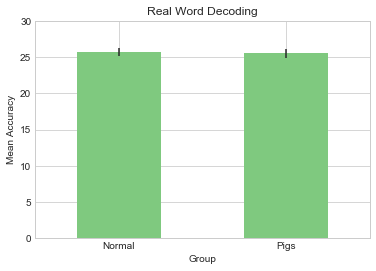

In [13]:
word_grouped = pigs_x_word.groupby(['condition'])['acc'].mean()
word_error = pigs_x_word.groupby(['condition'])['acc'].sem()

fig1 = word_grouped.plot(kind='bar', yerr=word_error, style='seaborn-whitegrid',
                                      legend=False, title='Real Word Decoding', 
                                      rot=0,  colormap='Accent')
fig1.set_xlabel('Group')
fig1.set_ylabel('Mean Accuracy')
fig1.set_ylim((0,30))
fig1.set_xticklabels(['Normal', 'Pigs']), 

#save file
plt.savefig('pigs_x_word.svg',transparent=True)

##### PSEUDO WORD DECODING

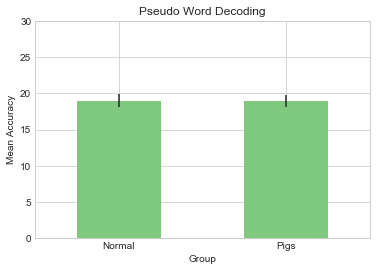

In [14]:
pseudo_grouped = pigs_x_pseudo.groupby(['condition'])['acc'].mean()
pseudo_error = pigs_x_pseudo.groupby(['condition'])['acc'].sem()

fig2 = pseudo_grouped.plot(kind='bar', yerr=pseudo_error, style='seaborn-whitegrid',
                                      legend=False, title='Pseudo Word Decoding', 
                                      rot=0,  colormap='Accent')
fig2.set_xlabel('Group')
fig2.set_ylabel('Mean Accuracy')
fig2.set_ylim((0,30))
fig2.set_xticklabels(['Normal', 'Pigs']), 

#save file
plt.savefig('pigs_x_pseudo.svg',transparent=True)

### PASSAGE DATA

#### REFORMAT DATA

In [15]:
# remove subjects with missing data
pigs_x_data = pigs_x_data.dropna(axis='rows', how='any', subset=['pigs_p1_r1_acc', 'pigs_p1_r1_time', 
                                                                 'pigs_p2_r1_acc', 'pigs_p2_r1_time'])
# convert accuracy and time data to numeric
pigs_x_data['pigs_p1_r1_acc'] = pd.to_numeric(pigs_x_data['pigs_p1_r1_acc'], errors='coerce')
pigs_x_data['pigs_p2_r1_acc'] = pd.to_numeric(pigs_x_data['pigs_p2_r1_acc'], errors='coerce')
pigs_x_data['pigs_p1_r1_time'] = pd.to_numeric(pigs_x_data['pigs_p1_r1_time'], errors='coerce')
pigs_x_data['pigs_p2_r1_time'] = pd.to_numeric(pigs_x_data['pigs_p2_r1_time'], errors='coerce')

# reset index and delete previous index column
pigs_x_data = pigs_x_data.reset_index()
del pigs_x_data['index']

In [16]:
# create rate variable
for ii in range(0, len(pigs_x_data['record_id'])):
    pigs_x_data.loc[ii, 'pigs_p1_r1_rate'] = pigs_x_data.loc[ii, 'pigs_p1_r1_acc']/pigs_x_data.loc[ii, 'pigs_p1_r1_time']
    pigs_x_data.loc[ii, 'pigs_p2_r1_rate'] = pigs_x_data.loc[ii, 'pigs_p2_r1_acc']/pigs_x_data.loc[ii, 'pigs_p2_r1_time']

In [17]:
# convert wide format to long format
pigs_x_acc = pd.melt(pigs_x_data, id_vars = ['record_id', 'pigs_group'], value_name = 'acc', var_name = 'passage', 
                        value_vars = ['pigs_p1_r1_acc', 'pigs_p2_r1_acc'])
pigs_x_acc['acc'] = pd.to_numeric(pigs_x_acc['acc'], errors='coerce')

In [18]:
# convert wide format to long format
pigs_x_rate = pd.melt(pigs_x_data, id_vars = ['record_id', 'pigs_group'], value_name = 'rate', var_name = 'passage', 
                        value_vars = ['pigs_p1_r1_rate', 'pigs_p2_r1_rate'])
pigs_x_rate['rate'] = pd.to_numeric(pigs_x_rate['rate'], errors='coerce')

#### APPLY CODING STRUCTURE BY GROUP AND PASSAGE

In [19]:
# initialize coding variables
pigs_x_acc['condition'] = np.nan
pigs_x_acc['story'] = np.nan
pigs_x_rate['condition'] = np.nan
pigs_x_rate['story'] = np.nan

In [20]:
# loop through data and apply condition and story variable based on redcap coding 
# structure and study design randomization
for ii in range(0, len(pigs_x_acc['record_id'])):
        if pigs_x_acc['pigs_group'][ii] == 0.0:
                if pigs_x_acc['passage'][ii] == 'pigs_p1_r1_acc':
                    pigs_x_acc.loc[ii,'condition'] = 'normal'
                    pigs_x_acc.loc[ii,'story'] = 'friend'
                elif pigs_x_acc['passage'][ii] == 'pigs_p2_r1_acc':
                    pigs_x_acc.loc[ii, 'condition'] = 'pigs'
                    pigs_x_acc.loc[ii,'story'] = 'animal'
                else:
                    raise Exception('Error computing condition & story (bad passage, group 0)')
        elif pigs_x_acc['pigs_group'][ii] == 1.0:
                if pigs_x_acc['passage'][ii] == 'pigs_p1_r1_acc':
                    pigs_x_acc.loc[ii,'condition'] = 'normal'
                    pigs_x_acc.loc[ii,'story'] = 'animal'
                elif pigs_x_acc['passage'][ii] == 'pigs_p2_r1_acc':
                    pigs_x_acc.loc[ii, 'condition'] = 'pigs'
                    pigs_x_acc.loc[ii,'story'] = 'friend'
                else:
                    raise Exception('Error computing condition & story (bad passage, group 1)')
        elif pigs_x_acc['pigs_group'][ii] == 2.0:
                if pigs_x_acc['passage'][ii] == 'pigs_p1_r1_acc':
                        pigs_x_acc.loc[ii,'condition'] = 'pigs'
                        pigs_x_acc.loc[ii,'story'] = 'friend'
                elif pigs_x_acc['passage'][ii] == 'pigs_p2_r1_acc':
                    pigs_x_acc.loc[ii, 'condition'] = 'normal'
                    pigs_x_acc.loc[ii,'story'] = 'animal'
                else:
                    raise Exception('Error computing condition & story (bad passage, group 2)')
        elif pigs_x_acc['pigs_group'][ii] == 3.0:
                if pigs_x_acc['passage'][ii] == 'pigs_p1_r1_acc':
                        pigs_x_acc.loc[ii,'condition'] = 'pigs'
                        pigs_x_acc.loc[ii,'story'] = 'animal'
                elif pigs_x_acc['passage'][ii] == 'pigs_p2_r1_acc':
                    pigs_x_acc.loc[ii, 'condition'] = 'normal'
                    pigs_x_acc.loc[ii,'story'] = 'friend'
                else:
                    raise Exception('Error computing condition & story (bad passage, group 3)')
        elif math.isnan(pigs_x_acc['pigs_group'][ii]):
            continue
        else:
            raise Exception('Error computing passage (bad pigs group)')

In [21]:
# repeat for rate structure
for ii in range(0, len(pigs_x_rate['record_id'])):
        if pigs_x_rate['pigs_group'][ii] == 0.0:
                if pigs_x_rate['passage'][ii] == 'pigs_p1_r1_rate':
                    pigs_x_rate.loc[ii,'condition'] = 'normal'
                    pigs_x_rate.loc[ii,'story'] = 'friend'
                elif pigs_x_rate['passage'][ii] == 'pigs_p2_r1_rate':
                    pigs_x_rate.loc[ii, 'condition'] = 'pigs'
                    pigs_x_rate.loc[ii,'story'] = 'animal'
                else:
                    raise Exception('Error computing condition & story (bad passage, group 0)')
        elif pigs_x_rate['pigs_group'][ii] == 1.0:
                if pigs_x_rate['passage'][ii] == 'pigs_p1_r1_rate':
                    pigs_x_rate.loc[ii,'condition'] = 'normal'
                    pigs_x_rate.loc[ii,'story'] = 'animal'
                elif pigs_x_rate['passage'][ii] == 'pigs_p2_r1_rate':
                    pigs_x_rate.loc[ii, 'condition'] = 'pigs'
                    pigs_x_rate.loc[ii,'story'] = 'friend'
                else:
                    raise Exception('Error computing condition & story (bad passage, group 1)')
        elif pigs_x_rate['pigs_group'][ii] == 2.0:
                if pigs_x_rate['passage'][ii] == 'pigs_p1_r1_rate':
                        pigs_x_rate.loc[ii,'condition'] = 'pigs'
                        pigs_x_rate.loc[ii,'story'] = 'friend'
                elif pigs_x_rate['passage'][ii] == 'pigs_p2_r1_rate':
                    pigs_x_rate.loc[ii, 'condition'] = 'normal'
                    pigs_x_rate.loc[ii,'story'] = 'animal'
                else:
                    raise Exception('Error computing condition & story (bad passage, group 2)')
        elif pigs_x_rate['pigs_group'][ii] == 3.0:
                if pigs_x_rate['passage'][ii] == 'pigs_p1_r1_rate':
                        pigs_x_rate.loc[ii,'condition'] = 'pigs'
                        pigs_x_rate.loc[ii,'story'] = 'animal'
                elif pigs_x_rate['passage'][ii] == 'pigs_p2_r1_rate':
                    pigs_x_rate.loc[ii, 'condition'] = 'normal'
                    pigs_x_rate.loc[ii,'story'] = 'friend'
                else:
                    raise Exception('Error computing condition & story (bad passage, group 3)')
        elif math.isnan(pigs_x_rate['pigs_group'][ii]):
            continue
        else:
            raise Exception('Error computing passage (bad pigs group)')

In [22]:
# convert accuracy variable to proportion, accounting for varying passage lengths
friend_len = 226
animal_len = 242
for ii in range(len(pigs_x_acc['record_id'])):
    if np.isnan(pigs_x_acc.loc[ii, 'acc']):
        continue
    elif pigs_x_acc.loc[ii, 'story'] == 'friend':
        pigs_x_acc.loc[ii, 'acc'] = pigs_x_acc.loc[ii, 'acc']/friend_len
    elif pigs_x_acc.loc[ii, 'story'] == 'animal':
        pigs_x_acc.loc[ii, 'acc'] = pigs_x_acc.loc[ii, 'acc']/animal_len

### PLOTTING

##### PASSAGE READING ACCURACY

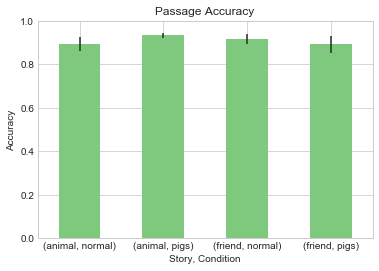

In [23]:
acc_grouped = pigs_x_acc.groupby(['story', 'condition'])['acc'].mean()
acc_error = pigs_x_acc.groupby(['story', 'condition'])['acc'].sem()

fig3 = acc_grouped.plot(kind='bar', yerr=acc_error, style='seaborn-whitegrid',
                                      legend=False, title='Passage Accuracy',
                                        rot=0,  colormap='Accent')
fig3.set_xlabel('Story, Condition')
fig3.set_ylabel('Accuracy')
fig3.set_ylim((0,1)) 

#save file
plt.savefig('pigs_x_acc.svg',transparent=True)

##### PASSAGE READING RATE

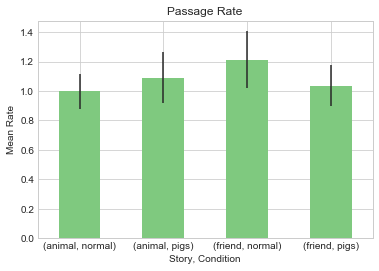

In [24]:
rate_grouped = pigs_x_rate.groupby(['story', 'condition'])['rate'].mean()
rate_error = pigs_x_rate.groupby(['story', 'condition'])['rate'].sem()

fig4 = rate_grouped.plot(kind='bar', yerr=rate_error, style='seaborn-whitegrid',
                                      legend=False, title='Passage Rate', 
                                      rot=0, colormap='Accent')
fig4.set_xlabel('Story, Condition')
fig4.set_ylabel('Mean Rate')


#save file
plt.savefig('pigs_x_rate.svg',transparent=True)

### PREDICTORS

In [25]:
# get api token
# if you need an access token, consult the RedCap API page
home = os.path.expanduser('~')
with open (home+"/Desktop/redcap_apitoken_repo.txt", "r") as myfile:
    token=myfile.read().split()
intake_report = {
    'token': token,
    'content': 'report',
    'format': 'csv',
    'report_id': '20197',
    'rawOrLabel': 'raw',
    'rawOrLabelHeaders': 'raw',
    'exportCheckboxLabel': 'false',
    'returnFormat': 'csv'
}
# specify API address
redcap_path = 'https://redcap.iths.org/api/'
# use requests module to pull data from database using api token
# and convert to csv
pull_intake = requests.post(redcap_path, data=intake_report)
intake_report_filename =os.path.join(home+'/Downloads/intake_data.csv')
with open(intake_report_filename, 'w') as report_file:
        report_file.write(pull_intake.text)
intake_data = pd.read_csv(intake_report_filename)

In [26]:
intake_data = intake_data[['record_id', 'wj_brs', 'twre_index', 'ctopp_rapid']]
pigs_x_word = pigs_x_word.merge(intake_data, on='record_id')
pigs_x_pseudo = pigs_x_pseudo.merge(intake_data, on='record_id')
pigs_x_acc = pigs_x_acc.merge(intake_data, on='record_id')
pigs_x_rate = pigs_x_rate.merge(intake_data, on='record_id')

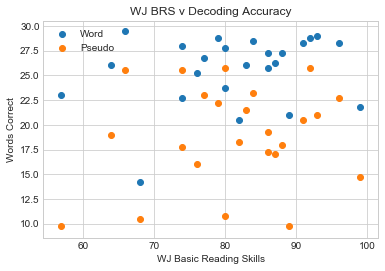

In [27]:
plt.scatter(pigs_x_word.groupby(['record_id'])['wj_brs'].mean(), 
            pigs_x_word.groupby(['record_id'])['acc'].mean(), label='Word')
plt.scatter(pigs_x_pseudo.groupby(['record_id'])['wj_brs'].mean(), 
            pigs_x_pseudo.groupby(['record_id'])['acc'].mean(), label='Pseudo')
plt.title('WJ BRS v Decoding Accuracy')
plt.xlabel('WJ Basic Reading Skills')
plt.ylabel('Words Correct')
plt.legend()

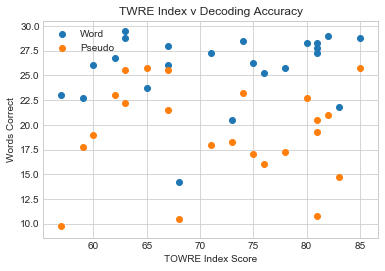

In [28]:
plt.scatter(pigs_x_word.groupby(['record_id'])['twre_index'].mean(), 
            pigs_x_word.groupby(['record_id'])['acc'].mean(), label='Word')
plt.scatter(pigs_x_pseudo.groupby(['record_id'])['twre_index'].mean(), 
            pigs_x_pseudo.groupby(['record_id'])['acc'].mean(), label='Pseudo')
plt.title('TWRE Index v Decoding Accuracy')
plt.xlabel('TOWRE Index Score')
plt.ylabel('Words Correct')
plt.legend()

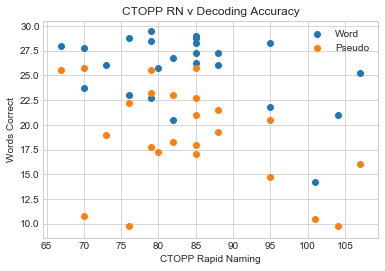

In [29]:
plt.scatter(pigs_x_word.groupby(['record_id'])['ctopp_rapid'].mean(), 
            pigs_x_word.groupby(['record_id'])['acc'].mean(), label='Word')
plt.scatter(pigs_x_pseudo.groupby(['record_id'])['ctopp_rapid'].mean(), 
            pigs_x_pseudo.groupby(['record_id'])['acc'].mean(), label='Pseudo')
plt.title('CTOPP RN v Decoding Accuracy')
plt.xlabel('CTOPP Rapid Naming')
plt.ylabel('Words Correct')
plt.legend()

#### EXPORT DATA TO CSV FOR LME ANALYSIS IN MATLAB

In [30]:
pigs_x_word.to_csv(home+'/Desktop/pigs_x_word.csv')
pigs_x_pseudo.to_csv(home+'/Desktop/pigs_x_pseudo.csv')
pigs_x_acc.to_csv(home+'/Desktop/pigs_x_acc.csv')
pigs_x_rate.to_csv(home+'/Desktop/pigs_x_rate.csv')